# Counterfeit detection

The task in this assignment is to detect the  counterfeit banknotes. The data set is based on [banknote authentication Data Set ](https://archive.ics.uci.edu/ml/datasets/banknote+authentication#) from UCI Machine Learning repository. The first three columns denote different parameters obtained from the photographs of the banknotes and last colum provides the label. Frankly as the dataset does not have any description I don't know  which labels corresponds to real and which to counterfeited banknotes. let's assume that label one (positive) denotes the clounterfeits. The set  "banknote_authentication.csv" can be found in the data  directory.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sn
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
import sys
sys.path.append("../../")

In [122]:
data = pd.read_csv('banknote_authentication.csv')

In [123]:
data.head()

,a1,a2,a3,counterfeit
0,12.3784,0.70403,-7.58360,0
1,8.1881,-3.13380,-2.52760,0
2,-10.8679,9.49260,-1.41160,1
3,-8.7903,7.97350,-0.45475,1
4,-5.5167,10.93900,-0.40820,1


## Problem 

### A.

Perform the Quadratic Discriminant Analysis on this set. Calculate the confusion matrix, AUC score and plot the ROC curve. 

In [63]:
np.bincount(data['counterfeit'])

array([609, 488])

In [124]:
#train test split
X = np.array(data[["a1", "a2", "a3"]])
y = np.array(data["counterfeit"])
X_train, X_test, y_train, y_test = train_test_split(X, y)
len(y_test)

275

In [90]:
#mdoel training
model = QuadraticDiscriminantAnalysis()
model.fit(X_train, y_train)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [91]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, :1]

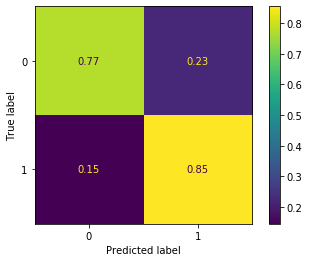

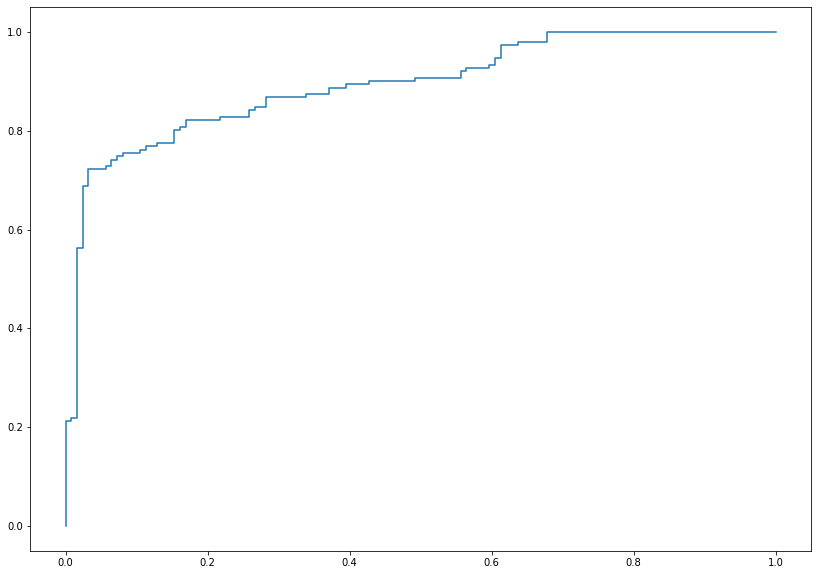

ROC AUC score: 0.10670796838282419


In [92]:
#model statistics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fpr, tpr, thds = roc_curve(y_test, y_proba, pos_label = 1)
auc = roc_auc_score(y_test, y_proba)

#plot confusion matrix
plot_confusion_matrix(model, X_test, y_test, normalize = 'true')

#plot roc curve
plt.figure(figsize = (14, 10))
plt.plot(tpr, fpr)
plt.show()

print("ROC AUC score: {}".format(auc))

### B.

Perform Gaussian Mixture Discriminant Analysis on this set as described in the `gaussian_mixture_model_EM_algorithm` notebook. Use two components for positives and two components for negatives. Calculate the confusion matrix, AUC score and plot the ROC curve. 

In [125]:
bnknts0_cmp = GaussianMixture(n_components=2, max_iter=100, tol=0.0001)
bnknts1_cmp = GaussianMixture(n_components=2, max_iter=100, tol=0.0001)

In [126]:
bnknts0 = X_train[y_train == 0]
bnknts1 = X_train[y_train == 1]

In [127]:
bnknts0_cmp.fit(bnknts0)
bnknts1_cmp.fit(bnknts1)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.0001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [128]:
def make_pdf(cmp):
    """
    Takes a GaussianMixture object and returns corresponding
    probability distribution function
    """
    n_cmp = cmp.n_components
    dists = [st.multivariate_normal(cmp.means_[i], cmp.covariances_[i]) for i in range(n_cmp)]
    def pdf(x):
        p = 0.0
        for i in range(n_cmp):
            p+= cmp.weights_[i]*dists[i].pdf(x)
        return p
    
    return pdf
        
def make_predict_proba(cmp0, cmp1, pi0=0.5, pi1=.5):
    """
    Takes two GaussianMixture object and corresponding priors and returns 
    pdf for conditional probability P(c=1|x)
    """
    pdf0 = make_pdf(cmp0)
    pdf1 = make_pdf(cmp1)
    def p(x):
        p0=pi0*pdf0(x)
        p1=pi1*pdf1(x)
        return p1/(p1+p0)    
        
    return p

In [129]:
mgd_predict_proba = make_predict_proba(bnknts0_cmp, bnknts1_cmp, 0.5, 0.5)

In [137]:
mgd_proba = mgd_predict_proba(X_test)

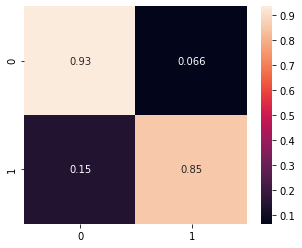

In [135]:
cm = confusion_matrix(y_test, mgd_proba>0.5, normalize='true')

plt.figure(figsize = (5, 4))
sn.heatmap(cm, annot = True)

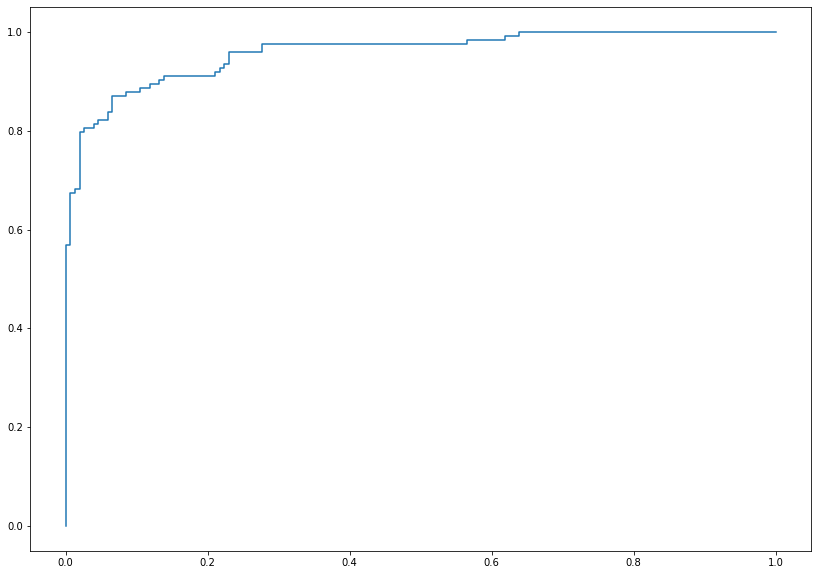

ROC AUC score: 0.9580124090714591


In [132]:
mgd_fpr, mgd_tpr, mgd_thds = roc_curve(y_test, mgd_proba, pos_label = 1)
mgd_auc = roc_auc_score(y_test, mgd_proba)

plt.figure(figsize = (14, 10))
plt.plot(mgd_fpr, mgd_tpr)
plt.show()

print("ROC AUC score: {}".format(mgd_auc))

### C.

Use k-fold cross validation to find the optimal number of gaussian components for each class. As before calculate the confusion matrix, AUC score and plot the ROC curve for the best classifier. 

In [133]:
max_avg_auc = 0
skf = StratifiedKFold(n_splits = 3)

for i in range(2, 20):
    for j in range(2, 20):
        accuracies = []
        bnknts0_cmp_kfold = GaussianMixture(n_components = i, max_iter = 100, tol = 0.0001)
        bnknts1_cmp_kfold = GaussianMixture(n_components = j, max_iter = 100, tol = 0.0001)

        for train_index, test_index in skf.split(X, y):
            X_train_kfold, X_test_kfold = X[train_index], X[test_index]
            y_train_kfold, y_test_kfold = y[train_index], y[test_index]
            
            bnknts0_kfold = X_train_kfold[y_train_kfold == 0]
            bnknts1_kfold = X_train_kfold[y_train_kfold == 1]
            
            bnknts0_cmp_kfold.fit(bnknts0_kfold)
            bnknts1_cmp_kfold.fit(bnknts1_kfold)
            
            mgd_predict_proba_kfold = make_predict_proba(bnknts0_cmp_kfold, bnknts1_cmp_kfold, 0.5, 0.5)
            mgd_proba_kfold = mgd_predict_proba_kfold(X_test_kfold)
            mgd_auc_kfold = roc_auc_score(y_test_kfold, mgd_proba_kfold)
            accuracies.append(mgd_auc_kfold)
        
        accuracies = np.array(accuracies)
            
        avg_auc = np.average(accuracies)
        
        if avg_auc > max_avg_auc:
            max_avg_auc = avg_auc
            n_components0 = i
            n_components1 = j
    
print(n_components0)
print(n_components1)
print(max_avg_auc)

/home/arek/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


15
12
0.9943878754728953


In [138]:
len(mgd_proba)

275

In [139]:
best_bnknts0_cmp = GaussianMixture(n_components = n_components0, max_iter = 100, tol = 0.0001)
best_bnknts1_cmp = GaussianMixture(n_components = n_components1, max_iter = 100, tol = 0.0001)

In [140]:
best_bnknts0 = X_train[y_train == 0]
best_bnknts1 = X_train[y_train == 1]

In [141]:
best_bnknts0_cmp.fit(best_bnknts0)
best_bnknts1_cmp.fit(best_bnknts1)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=12, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.0001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [142]:
best_mgd_predict_proba = make_predict_proba(best_bnknts0_cmp, best_bnknts1_cmp, 0.5, 0.5)

In [143]:
best_mgd_proba = best_mgd_predict_proba(X_test)

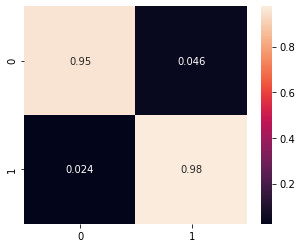

In [144]:
best_cm = confusion_matrix(y_test, best_mgd_proba > 0.5, normalize='true')

plt.figure(figsize = (5, 4))
sn.heatmap(best_cm, annot = True)

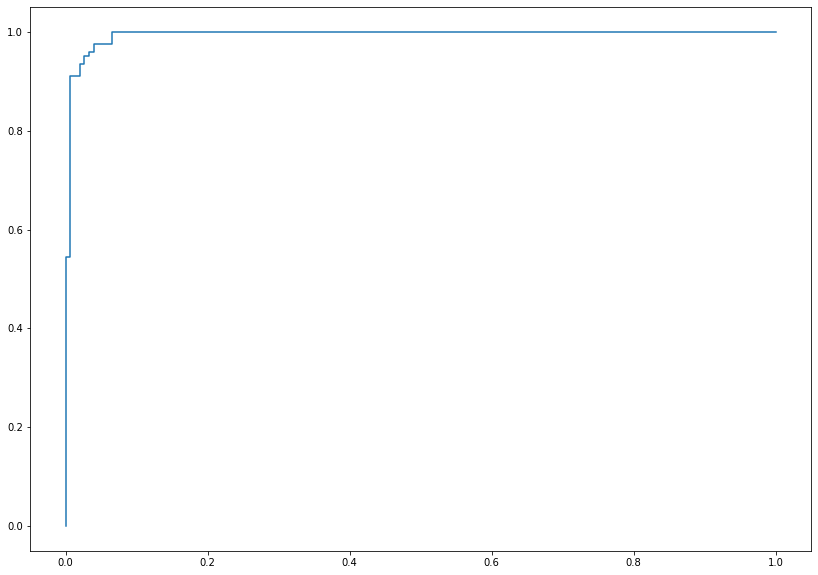

ROC AUC score: 0.9941698759092855


In [145]:
best_mgd_fpr, best_mgd_tpr, best_mgd_thds = roc_curve(y_test, best_mgd_proba, pos_label = 1)
best_mgd_auc = roc_auc_score(y_test, best_mgd_proba)

plt.figure(figsize = (14, 10))
plt.plot(best_mgd_fpr, best_mgd_tpr)
plt.show()

print("ROC AUC score: {}".format(best_mgd_auc))

__Hint__ use the `StratifiedKFold` function from scikit-learn library to generate folds. 

## D.  

Assume that 1% of all the customers in your store presents a counterfeit 100PLN bill. If you accept the counterfeit bill you loose 100PLN. If you reject a valid bill,  you may loose the purchase, you estimate this loss as 15PLN on average. For each of the three classifiers find the threshold that minimises your losses and calculates the minimum loss for each classifier. Show the optimal classifiers points on the ROC curves.

In [146]:
def check_thds(y_test, y_proba):
    thds = np.linspace(0, 1, 100)
    max_profit = 0
    best_thd = 0

    for thd in thds:
        tn, fp, fn, tp  = confusion_matrix(y_test, y_proba > thd, normalize='true').ravel()
        profit = -100 * fp + (-15 * fn) + 100 * tp

        if profit > max_profit:
            max_profit = profit
            best_thd = thd
            
    return best_thd

#fp -100
#fn -15
#tn 0
#tp +100

#1/100

In [169]:
best_mgd_thd = check_thds(y_test, best_mgd_proba)
mgd_thd = check_thds(y_test, mgd_proba)
qd_thd = check_thds(y_test, y_proba)

print("quadratic discriminant threshold: {}".format(qd_thd))
print("mgd threshold: {}".format(mgd_thd))
print("best_mgd threshold: {}".format(best_mgd_thd))

quadratic discriminant threshold: 0.888888888888889
mgd threshold: 0.4444444444444445
best_mgd threshold: 0.393939393939394
